In [1]:
# initialising the llm
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o",api_key=os.environ["OPENAI_API_KEY"])
result = llm.invoke("what is capital of india")
print(result)

content='The capital of India is New Delhi.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 12, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bx8OOWcDG7fUiy8orbiQAEtIYUkwu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--5b18c715-c58b-4a13-a18f-1262e54bd88d-0' usage_metadata={'input_tokens': 12, 'output_tokens': 8, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [2]:
from pydantic import BaseModel,Field
from typing import Literal

class Route(BaseModel):
    step : Literal["poem","story","joke"]= Field(description="the next step in the routing process")

router = llm.with_structured_output(Route)

In [3]:
result = router.invoke("write joke on college life")
print(result.step)

joke


In [4]:
from typing_extensions import TypedDict
class State(TypedDict):
    topic:str
    decision: str
    output:str


In [5]:
def llm_call_1(state:State):
    "--- writes a poem ---"
    return {"output":llm.invoke(f"write a poem on {state["topic"]}").content}

def llm_call_2(state:State):
    "--- writes a story ---"
    return {"output":llm.invoke(f"write a story on {state["topic"]}").content}

def llm_call_3(state:State):
    "--- writes a joke ---"
    return {"output":llm.invoke(f"write a joke on {state["topic"]}").content}

In [6]:
from langchain_core.messages import SystemMessage,HumanMessage
def llm_router(state:State):
    decision=router.invoke(
        [
            SystemMessage(
                content="Route the input to story,joke or poem based on the users request"
            ),
            HumanMessage(content=state["topic"])
        ]
    )
    return {"decision" : decision.step}

In [7]:
def route_decision(state:State):
    return state["decision"]

from langgraph.graph import StateGraph,START,END

graph_builder = StateGraph(State)
graph_builder.add_node("llm_router",llm_router)
graph_builder.add_node("llm_call_1",llm_call_1)
graph_builder.add_node("llm_call_2",llm_call_2)
graph_builder.add_node("llm_call_3",llm_call_3)

graph_builder.add_edge(START,"llm_router")
graph_builder.add_conditional_edges("llm_router",route_decision,
                                    {
                                        "poem":"llm_call_1",
                                        "story":"llm_call_2",
                                        "joke":"llm_call_3"
})
graph_builder.add_edge("llm_call_1",END)
graph_builder.add_edge("llm_call_2",END)
graph_builder.add_edge('llm_call_3',END)

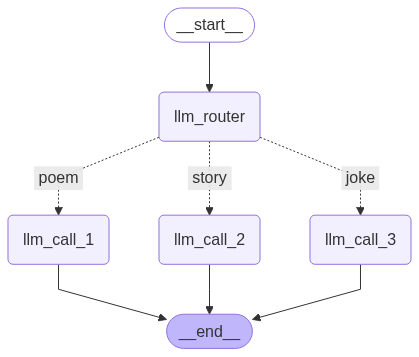

In [8]:
graph = graph_builder.compile()

from IPython.display import Image,display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from pprint import pprint
graph.invoke({"topic":'write poem on computer'})

{'topic': 'write poem on computer',
 'decision': 'poem',
 'output': "In the glow of a screen, where the wires weave,  \nA realm of logic where our dreams conceive.  \nA processor hums with a rhythm so tight,  \nTurning thoughts into bytes in the vast digital night.  \n\nKeys clatter softly, a modern-day quill,  \nSpinning tales through the bits with mechanical skill.  \nHere in the circuits, the sparks come alive,  \nIn binary whispers, the verses thrive.  \n\nA canvas of code, both vast and sublime,  \nWhere electrons dance in a virtual rhyme.  \nWith silicon heart, the machine starts to sing,  \nOf future and past, with a digital wing.  \n\nIts memory vast, an infinite scroll,  \nCapturing echoes of humanity's soul.  \nYet even in logic, there's art to be found,  \nWhere creativity and machine are bound.  \n\nOh, mighty computer, both humble and grand,  \nA tool of creation in binary land.  \nTogether we journey, exploring unknowns,  \nIn the dance of our fingertips, poetry is sown. 